In [1]:
import numpy as np
import torch
import torch.nn
import torch.optim
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, ReLU, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, nested_detach
import base_module
from executor import single_train_loop, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging
import logger
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
init_logging()

datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs
datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs


In [3]:
dataset_environment_str = "T4_CPUALL"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False

In [4]:
train_configs = {
    ModelType.MLP.name: Config.from_dict({
        "model": "MLP",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-4,
        "epochs": 10,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.PerfNet.name: Config.from_dict({
        "model": "PerfNet",
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": True,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-4,
        "epochs": 10,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    })
}

model_type = ModelType.MLP
conf = train_configs[model_type.name]

In [5]:
eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=10)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=100)

[2023-12-13 17:16:00,918] {data.py:441} INFO - Loading graphs train
[2023-12-13 17:16:00,918] {data.py:412} INFO - Loading merged.csv
[2023-12-13 17:16:00,918] {data.py:412} INFO - Loading merged.csv
[2023-12-13 17:16:00,924] {data.py:415} INFO - Loaded merged.csv, 10 rows
[2023-12-13 17:16:00,930] {data.py:421} INFO - Loaded mnasnet1_3.180_7.csv, 10 rows
[2023-12-13 17:16:00,931] {data.py:441} INFO - Loading graphs train
[2023-12-13 17:16:00,932] {data.py:412} INFO - Loading merged.csv
[2023-12-13 17:16:00,937] {data.py:415} INFO - Loaded merged.csv, 100 rows
[2023-12-13 17:16:00,985] {data.py:421} INFO - Loaded mnasnet1_3.180_7.csv, 100 rows


In [6]:
len(eval_graphs), len(train_graphs)

(1, 1)

In [7]:

def init_dataset(graphs: List[Graph]) -> MDataset:
    op_X, op_Y = list(), list()
    data_idx_to_graph = dict()
    counter = iter(count())
    op_feature_len = 0

    def node_features(g: Graph) -> Tuple[
        List[Dict], List[Dict]]:
        X, Y = list(), list()
        for i, node in enumerate(g.nodes):
            x_op_feature = node.op.to_feature_array("complex")
            x = {
                "x_op_feature": x_op_feature
            }
            node_durations = (node.duration,node.gap)
            x["x_id"] = i
            x["x_graph_id"] = g.ID
            y = {"y_node_durations": node_durations, "y_id": i, "y_graph_id": g.ID}
            X.append(x)
            Y.append(y)
        return X, Y

    for graph in graphs:
        X, Y = node_features(graph)
        for x in X:
            # if len(x['x_op_feature'])!=37:
            #     print(x['x_graph_id'], len(x['x_op_feature']))
            op_feature_len = max(op_feature_len, len(x["x_op_feature"]))
        op_X.extend(X)
        op_Y.extend(Y)
        for i in range(len(X)):
            data_idx_to_graph[next(counter)] = graph
    for x in op_X:
        v = x["x_op_feature"]
        x["x_op_feature"] = np.pad(v, (0, op_feature_len - v.size))

    dataset = MDataset(op_X, op_Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [8]:
def get_scalers(ds):
    scaler_cls = normalizer_cls
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array)
    y_array = np.array(y_array)

    op_feature_scaler = scaler_cls()
    op_feature_scaler.fit(op_feature_array)

    y_scaler = scaler_cls()
    y_scaler.fit(y_array)
    return op_feature_scaler, y_scaler

scalers = get_scalers(train_ds)
op_feature_scaler, y_scaler = scalers

In [9]:

def preprocess_dataset(ds: MDataset) -> MDataset:
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array, dtype=np.float32)
    y_array = np.array(y_array, dtype=np.float32)


    op_feature_array = op_feature_scaler.transform(op_feature_array)
    y_array = y_scaler.transform(y_array)

    processed_features = list()
    processed_labels = list()
    for i, data in enumerate(ds):
        feature, label = data
        processed_features.append({
            "x_id": feature["x_id"],
            "x_graph_id": feature["x_graph_id"],
            # 运行时再传到cuda那边
            # "x_op_feature": torch.Tensor(op_feature_array[i]).to(device=self.conf.device)
            "x_op_feature": torch.Tensor(op_feature_array[i])
        })
        processed_labels.append({
            "y_id": label["y_id"],
            "y_graph_id": label["y_graph_id"],
            # "y_node_durations": torch.Tensor(y_array[i]).to(device=self.conf.device)
            "y_node_durations": torch.Tensor(y_array[i])
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)

In [10]:
save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, "OpBased", 'train',
                         conf.dataset_normalization)
save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, "OpBased", 'eval',
                         conf.dataset_normalization)
save_scalers_pkl(scalers, conf.dataset_environment, "OpBased", 'train',
                         conf.dataset_normalization)

In [11]:
preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'train', 
                                         conf.dataset_normalization)
preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'eval',
                                        conf.dataset_normalization)
scalers = load_scalers_pkl(conf.dataset_environment, "OpBased", 'train',
                           conf.dataset_normalization)


Loading dataset T4_CPUALL OpBased train Standard
Loading dataset T4_CPUALL OpBased eval Standard
Loading scalers T4_CPUALL OpBased train, Standard


In [12]:
op_feature_scaler, y_scaler = scalers

In [13]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    batches_len = len(input_batches)

    def compute_op_durations(_logits):
        transformed: np.ndarray = y_scaler.inverse_transform(_logits)
        durations = transformed.sum(axis=1)
        return durations

    graph_id_to_duration_pred = defaultdict(int)
    for idx in range(batches_len):
        inputs = input_batches[idx]
        logits = output_batches[idx]
        logits = nested_detach(logits)
        logits = logits.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        op_durations = compute_op_durations(logits)
        for i, graph_id in enumerate(graph_ids):
            op_duration = op_durations[i].item()
            graph_id_to_duration_pred[graph_id] += op_duration
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [14]:

def to_device(conf, features, labels):
    features['x_op_feature'] = features["x_op_feature"].to(device=conf.device)
    labels['y_node_durations'] = labels['y_node_durations'].to(device=conf.device)
    return features, labels

In [15]:
class MLPModel(MModule):

    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]
    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [16, 32, 64],
            'epochs': [5, 10, 20, 30],
            'optimizer': ['Adam', 'SGD'],
        }
        # return {}
    
    def __init__(self, input_dimension, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.input = torch.nn.Linear(input_dimension, 256)
        self.relu1 = ReLU()
        self.dense1 = torch.nn.Linear(256, 128)
        self.relu2 = ReLU()
        self.dense2 = torch.nn.Linear(128, 64)
        self.relu3 = ReLU()
        self.output = torch.nn.Linear(64, output_dimension)
        self.loss_fn = L1Loss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = self.input(X)
        X = self.relu1(X)
        X = self.dense1(X)
        X = self.relu2(X)
        X = self.dense2(X)
        X = self.relu3(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_MLP_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    return MLPModel(input_dimension=len(sample_x_dict["x_op_feature"]),
                    output_dimension=len(sample_y_dict["y_node_durations"]))

In [16]:

class PerfNetModel(MModule):
    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]
    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [16, 32, 64],
            'epochs': [5, 10, 20, 30],
            'optimizer': ['Adam', 'SGD'],
        }
        # return {}

    def __init__(self, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = torch.nn.LazyConv1d(out_channels=32, kernel_size=3, bias=True, padding_mode='zeros')
        self.conv2 = torch.nn.LazyConv1d(out_channels=128, kernel_size=2, bias=True, padding_mode='zeros')
        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.LazyLinear(32)
        self.relu1 = ReLU()
        self.dense2 = torch.nn.LazyLinear(64)
        self.relu2 = ReLU()
        self.dense3 = torch.nn.LazyLinear(128)
        self.relu3 = ReLU()
        self.dense4 = torch.nn.LazyLinear(256)
        self.relu4 = ReLU()
        self.dropout = torch.nn.Dropout(p=0.3)
        self.output = torch.nn.LazyLinear(output_dimension)
        self.loss_fn = L1Loss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = torch.unsqueeze(X, dim=1)
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.flatten(X)
        X = self.dense1(X)
        X = self.relu1(X)
        X = self.dense2(X)
        X = self.relu2(X)
        X = self.dense3(X)
        X = self.relu3(X)
        X = self.dense4(X)
        X = self.relu4(X)
        X = self.dropout(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_PerfNet_model() -> MModule | Any:
    sample_y_dict = preprocessed_train_ds.labels[0]
    return PerfNetModel(output_dimension=len(sample_y_dict["y_node_durations"]))



In [17]:
init_model_funcs = {
    ModelType.MLP.name: init_MLP_model,
    ModelType.PerfNet.name: init_PerfNet_model,
}


init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)


In [20]:
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)

ValueError: batch_size should be a positive integer value, but got batch_size=[16, 32, 64]

[2023-12-13 17:16:02,835] {executor.py:50} INFO - ModelType.MLP grid search on common params: True, model specific grid search params name: {}.
[2023-12-13 17:16:02,836] {executor.py:52} INFO - total search items: 18.
[[42], [16, 32, 64], [False], ['T4_CPUALL'], ['Standard'], [{'duration_summed': False}], [10, 20], [5000], [1e-05, 0.0001, 0.001], [{'learning_rate': 0.005, 'meta_learning_rate': 0.001, 'meta_train_steps': 1000, 'meta_task_per_step': 8, 'meta_fast_adaption_step': 5, 'meta_dataset_train_environment_strs': ['T4_CPUALL'], 'meta_dataset_eval_environment_strs': ['T4_CPUALL']}], ['MLP'], ['Adam']]
[2023-12-13 17:16:02,836] {executor.py:82} INFO - MLP grid search 1/18 starts. curr time usage: 0.00s
[2023-12-13 17:16:02,837] {executor.py:84} INFO - MLP grid search conf 1/18 = {
    "all_seed": 42,
    "batch_size": 16,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed":

  0%|          | 0/7 [00:00<?, ?it/s]

[2023-12-13 17:16:03,471] {executor.py:111} INFO - ModelType.MLP trained for 0.631895194 seconds.
[2023-12-13 17:16:03,472] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:03,474] {executor.py:116} INFO - ModelType.MLP train loss: 0.997166097164154, eval metrics: {'eval_loss': 1.4415596723556519, 'MRE': 0.5100838696803104, 'MAE': 0.5100838696803104, 'RMSE': 6.463865430175781}
[2023-12-13 17:16:03,474] {executor.py:187} INFO - Saving model at step 0 with loss 0.997166097164154,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-02


100%|██████████| 7/7 [00:00<00:00, 10.80it/s]

[2023-12-13 17:16:03,489] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 7/7 [00:00<00:00, 528.59it/s]

[2023-12-13 17:16:03,505] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 7/7 [00:00<00:00, 516.69it/s]

[2023-12-13 17:16:03,520] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 7/7 [00:00<00:00, 508.51it/s]

[2023-12-13 17:16:03,535] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 7/7 [00:00<00:00, 494.39it/s]

[2023-12-13 17:16:03,551] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 7/7 [00:00<00:00, 530.52it/s]

[2023-12-13 17:16:03,566] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 7/7 [00:00<00:00, 508.41it/s]

[2023-12-13 17:16:03,582] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 7/7 [00:00<00:00, 538.95it/s]

[2023-12-13 17:16:03,596] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 7/7 [00:00<00:00, 513.74it/s]

[2023-12-13 17:16:03,612] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 7/7 [00:00<00:00, 497.60it/s]


[2023-12-13 17:16:03,835] {executor.py:93} INFO - MLP grid search 1/18 done. training duration: 1.00s
[2023-12-13 17:16:03,836] {executor.py:82} INFO - MLP grid search 2/18 starts. curr time usage: 1.00s
[2023-12-13 17:16:03,836] {executor.py:84} INFO - MLP grid search conf 2/18 = {
    "all_seed": 42,
    "batch_size": 16,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 10,
    "eval_steps": 5000,
    "learning_rate": 0.0001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model_p

  0%|          | 0/7 [00:00<?, ?it/s]

[2023-12-13 17:16:03,843] {executor.py:111} INFO - ModelType.MLP trained for 0.004712233 seconds.
[2023-12-13 17:16:03,844] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:03,846] {executor.py:116} INFO - ModelType.MLP train loss: 0.6988771557807922, eval metrics: {'eval_loss': 1.4657838344573975, 'MRE': 0.5514220017101389, 'MAE': 0.5514220017101389, 'RMSE': 6.9877089360351565}
[2023-12-13 17:16:03,846] {executor.py:187} INFO - Saving model at step 0 with loss 0.6988771557807922,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-03


100%|██████████| 7/7 [00:00<00:00, 343.38it/s]

[2023-12-13 17:16:03,861] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 7/7 [00:00<00:00, 502.30it/s]

[2023-12-13 17:16:03,877] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 7/7 [00:00<00:00, 494.86it/s]

[2023-12-13 17:16:03,893] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 7/7 [00:00<00:00, 520.88it/s]

[2023-12-13 17:16:03,908] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 7/7 [00:00<00:00, 525.28it/s]

[2023-12-13 17:16:03,923] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 7/7 [00:00<00:00, 561.48it/s]

[2023-12-13 17:16:03,937] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 7/7 [00:00<00:00, 535.19it/s]

[2023-12-13 17:16:03,952] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 7/7 [00:00<00:00, 525.56it/s]

[2023-12-13 17:16:03,967] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 7/7 [00:00<00:00, 517.40it/s]

[2023-12-13 17:16:03,982] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 7/7 [00:00<00:00, 546.13it/s]


[2023-12-13 17:16:04,208] {executor.py:93} INFO - MLP grid search 2/18 done. training duration: 0.37s
[2023-12-13 17:16:04,209] {executor.py:82} INFO - MLP grid search 3/18 starts. curr time usage: 1.37s
[2023-12-13 17:16:04,210] {executor.py:84} INFO - MLP grid search conf 3/18 = {
    "all_seed": 42,
    "batch_size": 16,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 10,
    "eval_steps": 5000,
    "learning_rate": 0.001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model_pa

  0%|          | 0/7 [00:00<?, ?it/s]

[2023-12-13 17:16:04,216] {executor.py:111} INFO - ModelType.MLP trained for 0.004517579 seconds.
[2023-12-13 17:16:04,217] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:04,218] {executor.py:116} INFO - ModelType.MLP train loss: 1.0240881443023682, eval metrics: {'eval_loss': 1.4015405178070068, 'MRE': 0.5248640239104301, 'MAE': 0.5248640239104301, 'RMSE': 6.651161938964844}
[2023-12-13 17:16:04,219] {executor.py:187} INFO - Saving model at step 0 with loss 1.0240881443023682,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-04


100%|██████████| 7/7 [00:00<00:00, 374.15it/s]

[2023-12-13 17:16:04,232] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 7/7 [00:00<00:00, 518.46it/s]

[2023-12-13 17:16:04,248] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 7/7 [00:00<00:00, 545.58it/s]

[2023-12-13 17:16:04,262] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 7/7 [00:00<00:00, 549.66it/s]

[2023-12-13 17:16:04,277] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 7/7 [00:00<00:00, 520.26it/s]

[2023-12-13 17:16:04,292] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 7/7 [00:00<00:00, 480.95it/s]

[2023-12-13 17:16:04,308] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 7/7 [00:00<00:00, 506.83it/s]

[2023-12-13 17:16:04,324] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 7/7 [00:00<00:00, 537.42it/s]

[2023-12-13 17:16:04,338] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 7/7 [00:00<00:00, 525.19it/s]

[2023-12-13 17:16:04,353] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 7/7 [00:00<00:00, 484.56it/s]


[2023-12-13 17:16:04,578] {executor.py:93} INFO - MLP grid search 3/18 done. training duration: 0.37s
[2023-12-13 17:16:04,579] {executor.py:82} INFO - MLP grid search 4/18 starts. curr time usage: 1.74s
[2023-12-13 17:16:04,579] {executor.py:84} INFO - MLP grid search conf 4/18 = {
    "all_seed": 42,
    "batch_size": 16,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model_pa

  0%|          | 0/7 [00:00<?, ?it/s]

[2023-12-13 17:16:04,586] {executor.py:111} INFO - ModelType.MLP trained for 0.004455088 seconds.
[2023-12-13 17:16:04,586] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:04,588] {executor.py:116} INFO - ModelType.MLP train loss: 0.7346206903457642, eval metrics: {'eval_loss': 1.473238229751587, 'MRE': 0.5600651523252553, 'MAE': 0.5600651523252553, 'RMSE': 7.097236340820313}
[2023-12-13 17:16:04,588] {executor.py:187} INFO - Saving model at step 0 with loss 0.7346206903457642,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-04


100%|██████████| 7/7 [00:00<00:00, 358.06it/s]

[2023-12-13 17:16:04,603] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 7/7 [00:00<00:00, 520.09it/s]

[2023-12-13 17:16:04,618] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 7/7 [00:00<00:00, 510.14it/s]

[2023-12-13 17:16:04,634] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 7/7 [00:00<00:00, 509.25it/s]

[2023-12-13 17:16:04,649] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 7/7 [00:00<00:00, 486.47it/s]

[2023-12-13 17:16:04,665] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 7/7 [00:00<00:00, 498.23it/s]

[2023-12-13 17:16:04,681] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 7/7 [00:00<00:00, 496.01it/s]

[2023-12-13 17:16:04,697] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 7/7 [00:00<00:00, 516.17it/s]

[2023-12-13 17:16:04,712] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 7/7 [00:00<00:00, 502.94it/s]

[2023-12-13 17:16:04,728] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 7/7 [00:00<00:00, 517.61it/s]

[2023-12-13 17:16:04,743] {executor.py:150} INFO - ModelType.MLP training epoch 10



100%|██████████| 7/7 [00:00<00:00, 504.68it/s]

[2023-12-13 17:16:04,759] {executor.py:150} INFO - ModelType.MLP training epoch 11



100%|██████████| 7/7 [00:00<00:00, 472.47it/s]

[2023-12-13 17:16:04,775] {executor.py:150} INFO - ModelType.MLP training epoch 12



100%|██████████| 7/7 [00:00<00:00, 468.02it/s]

[2023-12-13 17:16:04,792] {executor.py:150} INFO - ModelType.MLP training epoch 13



100%|██████████| 7/7 [00:00<00:00, 469.49it/s]

[2023-12-13 17:16:04,809] {executor.py:150} INFO - ModelType.MLP training epoch 14



100%|██████████| 7/7 [00:00<00:00, 500.40it/s]

[2023-12-13 17:16:04,824] {executor.py:150} INFO - ModelType.MLP training epoch 15



100%|██████████| 7/7 [00:00<00:00, 514.39it/s]

[2023-12-13 17:16:04,840] {executor.py:150} INFO - ModelType.MLP training epoch 16



100%|██████████| 7/7 [00:00<00:00, 493.48it/s]

[2023-12-13 17:16:04,856] {executor.py:150} INFO - ModelType.MLP training epoch 17



100%|██████████| 7/7 [00:00<00:00, 382.79it/s]

[2023-12-13 17:16:04,876] {executor.py:150} INFO - ModelType.MLP training epoch 18



100%|██████████| 7/7 [00:00<00:00, 458.71it/s]

[2023-12-13 17:16:04,893] {executor.py:150} INFO - ModelType.MLP training epoch 19



100%|██████████| 7/7 [00:00<00:00, 458.91it/s]


[2023-12-13 17:16:05,241] {executor.py:93} INFO - MLP grid search 4/18 done. training duration: 0.66s
[2023-12-13 17:16:05,241] {executor.py:82} INFO - MLP grid search 5/18 starts. curr time usage: 2.41s
[2023-12-13 17:16:05,242] {executor.py:84} INFO - MLP grid search conf 5/18 = {
    "all_seed": 42,
    "batch_size": 16,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 0.0001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model_p

  0%|          | 0/7 [00:00<?, ?it/s]

[2023-12-13 17:16:05,248] {executor.py:111} INFO - ModelType.MLP trained for 0.004406704 seconds.
[2023-12-13 17:16:05,249] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:05,250] {executor.py:116} INFO - ModelType.MLP train loss: 0.7845523953437805, eval metrics: {'eval_loss': 1.4077452421188354, 'MRE': 0.5460039003934742, 'MAE': 0.5460039003934742, 'RMSE': 6.919049878417969}
[2023-12-13 17:16:05,251] {executor.py:187} INFO - Saving model at step 0 with loss 0.7845523953437805,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-05


100%|██████████| 7/7 [00:00<00:00, 340.49it/s]

[2023-12-13 17:16:05,267] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 7/7 [00:00<00:00, 485.86it/s]

[2023-12-13 17:16:05,283] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 7/7 [00:00<00:00, 463.42it/s]

[2023-12-13 17:16:05,300] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 7/7 [00:00<00:00, 496.92it/s]

[2023-12-13 17:16:05,316] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 7/7 [00:00<00:00, 479.81it/s]

[2023-12-13 17:16:05,332] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 7/7 [00:00<00:00, 487.00it/s]

[2023-12-13 17:16:05,348] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 7/7 [00:00<00:00, 487.15it/s]

[2023-12-13 17:16:05,364] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 7/7 [00:00<00:00, 487.53it/s]

[2023-12-13 17:16:05,381] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 7/7 [00:00<00:00, 490.41it/s]

[2023-12-13 17:16:05,397] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 7/7 [00:00<00:00, 482.36it/s]

[2023-12-13 17:16:05,413] {executor.py:150} INFO - ModelType.MLP training epoch 10



100%|██████████| 7/7 [00:00<00:00, 502.42it/s]

[2023-12-13 17:16:05,428] {executor.py:150} INFO - ModelType.MLP training epoch 11



100%|██████████| 7/7 [00:00<00:00, 501.39it/s]

[2023-12-13 17:16:05,444] {executor.py:150} INFO - ModelType.MLP training epoch 12



100%|██████████| 7/7 [00:00<00:00, 465.97it/s]

[2023-12-13 17:16:05,461] {executor.py:150} INFO - ModelType.MLP training epoch 13



100%|██████████| 7/7 [00:00<00:00, 487.46it/s]

[2023-12-13 17:16:05,477] {executor.py:150} INFO - ModelType.MLP training epoch 14



100%|██████████| 7/7 [00:00<00:00, 480.83it/s]

[2023-12-13 17:16:05,493] {executor.py:150} INFO - ModelType.MLP training epoch 15



100%|██████████| 7/7 [00:00<00:00, 460.96it/s]

[2023-12-13 17:16:05,510] {executor.py:150} INFO - ModelType.MLP training epoch 16



100%|██████████| 7/7 [00:00<00:00, 465.41it/s]

[2023-12-13 17:16:05,527] {executor.py:150} INFO - ModelType.MLP training epoch 17



100%|██████████| 7/7 [00:00<00:00, 473.67it/s]

[2023-12-13 17:16:05,544] {executor.py:150} INFO - ModelType.MLP training epoch 18



100%|██████████| 7/7 [00:00<00:00, 504.32it/s]

[2023-12-13 17:16:05,560] {executor.py:150} INFO - ModelType.MLP training epoch 19



100%|██████████| 7/7 [00:00<00:00, 509.82it/s]


[2023-12-13 17:16:05,786] {executor.py:93} INFO - MLP grid search 5/18 done. training duration: 0.55s
[2023-12-13 17:16:05,787] {executor.py:82} INFO - MLP grid search 6/18 starts. curr time usage: 2.95s
[2023-12-13 17:16:05,788] {executor.py:84} INFO - MLP grid search conf 6/18 = {
    "all_seed": 42,
    "batch_size": 16,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 0.001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model_pa

  0%|          | 0/7 [00:00<?, ?it/s]

[2023-12-13 17:16:05,794] {executor.py:111} INFO - ModelType.MLP trained for 0.004444814 seconds.
[2023-12-13 17:16:05,795] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:05,796] {executor.py:116} INFO - ModelType.MLP train loss: 0.8574100732803345, eval metrics: {'eval_loss': 1.4611402750015259, 'MRE': 0.5557249204003232, 'MAE': 0.5557249204003232, 'RMSE': 7.04223621875}
[2023-12-13 17:16:05,797] {executor.py:187} INFO - Saving model at step 0 with loss 0.8574100732803345,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-05


100%|██████████| 7/7 [00:00<00:00, 346.00it/s]

[2023-12-13 17:16:05,812] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 7/7 [00:00<00:00, 485.72it/s]

[2023-12-13 17:16:05,828] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 7/7 [00:00<00:00, 520.23it/s]

[2023-12-13 17:16:05,844] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 7/7 [00:00<00:00, 514.88it/s]

[2023-12-13 17:16:05,859] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 7/7 [00:00<00:00, 476.18it/s]

[2023-12-13 17:16:05,876] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 7/7 [00:00<00:00, 502.87it/s]

[2023-12-13 17:16:05,891] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 7/7 [00:00<00:00, 476.07it/s]

[2023-12-13 17:16:05,908] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 7/7 [00:00<00:00, 510.41it/s]

[2023-12-13 17:16:05,923] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 7/7 [00:00<00:00, 501.49it/s]

[2023-12-13 17:16:05,939] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 7/7 [00:00<00:00, 516.55it/s]

[2023-12-13 17:16:05,955] {executor.py:150} INFO - ModelType.MLP training epoch 10



100%|██████████| 7/7 [00:00<00:00, 489.21it/s]

[2023-12-13 17:16:05,971] {executor.py:150} INFO - ModelType.MLP training epoch 11



100%|██████████| 7/7 [00:00<00:00, 504.14it/s]

[2023-12-13 17:16:05,986] {executor.py:150} INFO - ModelType.MLP training epoch 12



100%|██████████| 7/7 [00:00<00:00, 482.97it/s]

[2023-12-13 17:16:06,003] {executor.py:150} INFO - ModelType.MLP training epoch 13



100%|██████████| 7/7 [00:00<00:00, 506.06it/s]

[2023-12-13 17:16:06,019] {executor.py:150} INFO - ModelType.MLP training epoch 14



100%|██████████| 7/7 [00:00<00:00, 503.41it/s]

[2023-12-13 17:16:06,034] {executor.py:150} INFO - ModelType.MLP training epoch 15



100%|██████████| 7/7 [00:00<00:00, 504.83it/s]

[2023-12-13 17:16:06,050] {executor.py:150} INFO - ModelType.MLP training epoch 16



100%|██████████| 7/7 [00:00<00:00, 503.95it/s]

[2023-12-13 17:16:06,066] {executor.py:150} INFO - ModelType.MLP training epoch 17



100%|██████████| 7/7 [00:00<00:00, 502.22it/s]

[2023-12-13 17:16:06,082] {executor.py:150} INFO - ModelType.MLP training epoch 18



100%|██████████| 7/7 [00:00<00:00, 487.18it/s]

[2023-12-13 17:16:06,098] {executor.py:150} INFO - ModelType.MLP training epoch 19



100%|██████████| 7/7 [00:00<00:00, 372.84it/s]


[2023-12-13 17:16:06,325] {executor.py:93} INFO - MLP grid search 6/18 done. training duration: 0.54s
[2023-12-13 17:16:06,326] {executor.py:82} INFO - MLP grid search 7/18 starts. curr time usage: 3.49s
[2023-12-13 17:16:06,327] {executor.py:84} INFO - MLP grid search conf 7/18 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 10,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model_pa

  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-13 17:16:06,333] {executor.py:111} INFO - ModelType.MLP trained for 0.00450221 seconds.
[2023-12-13 17:16:06,334] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:06,335] {executor.py:116} INFO - ModelType.MLP train loss: 0.8446316123008728, eval metrics: {'eval_loss': 1.4378060102462769, 'MRE': 0.57393808488626, 'MAE': 0.57393808488626, 'RMSE': 7.273036389648437}
[2023-12-13 17:16:06,336] {executor.py:187} INFO - Saving model at step 0 with loss 0.8446316123008728,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-06


100%|██████████| 4/4 [00:00<00:00, 281.62it/s]

[2023-12-13 17:16:06,345] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 4/4 [00:00<00:00, 446.98it/s]

[2023-12-13 17:16:06,356] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 4/4 [00:00<00:00, 458.07it/s]

[2023-12-13 17:16:06,366] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 4/4 [00:00<00:00, 449.68it/s]

[2023-12-13 17:16:06,377] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 4/4 [00:00<00:00, 458.64it/s]

[2023-12-13 17:16:06,387] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 4/4 [00:00<00:00, 457.59it/s]

[2023-12-13 17:16:06,398] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 4/4 [00:00<00:00, 456.70it/s]

[2023-12-13 17:16:06,409] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 4/4 [00:00<00:00, 477.96it/s]

[2023-12-13 17:16:06,419] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 4/4 [00:00<00:00, 459.51it/s]

[2023-12-13 17:16:06,429] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 4/4 [00:00<00:00, 454.37it/s]


[2023-12-13 17:16:06,646] {executor.py:93} INFO - MLP grid search 7/18 done. training duration: 0.32s
[2023-12-13 17:16:06,646] {executor.py:82} INFO - MLP grid search 8/18 starts. curr time usage: 3.81s
[2023-12-13 17:16:06,647] {executor.py:84} INFO - MLP grid search conf 8/18 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 10,
    "eval_steps": 5000,
    "learning_rate": 0.0001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model_p

  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-13 17:16:06,654] {executor.py:111} INFO - ModelType.MLP trained for 0.004525851 seconds.
[2023-12-13 17:16:06,654] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:06,656] {executor.py:116} INFO - ModelType.MLP train loss: 0.7510871887207031, eval metrics: {'eval_loss': 1.3934184312820435, 'MRE': 0.5207064471812308, 'MAE': 0.5207064471812308, 'RMSE': 6.598476453125}
[2023-12-13 17:16:06,656] {executor.py:187} INFO - Saving model at step 0 with loss 0.7510871887207031,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-06


100%|██████████| 4/4 [00:00<00:00, 289.36it/s]

[2023-12-13 17:16:06,665] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 4/4 [00:00<00:00, 508.85it/s]

[2023-12-13 17:16:06,675] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 4/4 [00:00<00:00, 494.63it/s]

[2023-12-13 17:16:06,685] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 4/4 [00:00<00:00, 512.74it/s]

[2023-12-13 17:16:06,694] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 4/4 [00:00<00:00, 510.97it/s]

[2023-12-13 17:16:06,704] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 4/4 [00:00<00:00, 517.27it/s]

[2023-12-13 17:16:06,713] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 4/4 [00:00<00:00, 529.88it/s]

[2023-12-13 17:16:06,722] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 4/4 [00:00<00:00, 528.15it/s]

[2023-12-13 17:16:06,731] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 4/4 [00:00<00:00, 499.54it/s]

[2023-12-13 17:16:06,741] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 4/4 [00:00<00:00, 468.14it/s]


[2023-12-13 17:16:06,990] {executor.py:93} INFO - MLP grid search 8/18 done. training duration: 0.34s
[2023-12-13 17:16:06,991] {executor.py:82} INFO - MLP grid search 9/18 starts. curr time usage: 4.15s
[2023-12-13 17:16:06,991] {executor.py:84} INFO - MLP grid search conf 9/18 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 10,
    "eval_steps": 5000,
    "learning_rate": 0.001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model_pa

  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-13 17:16:06,998] {executor.py:111} INFO - ModelType.MLP trained for 0.00464452 seconds.
[2023-12-13 17:16:06,998] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:07,000] {executor.py:116} INFO - ModelType.MLP train loss: 0.7651098966598511, eval metrics: {'eval_loss': 1.371841311454773, 'MRE': 0.5511686984535719, 'MAE': 0.5511686984535719, 'RMSE': 6.984499036132813}
[2023-12-13 17:16:07,000] {executor.py:187} INFO - Saving model at step 0 with loss 0.7651098966598511,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-06


100%|██████████| 4/4 [00:00<00:00, 278.62it/s]

[2023-12-13 17:16:07,010] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 4/4 [00:00<00:00, 492.04it/s]

[2023-12-13 17:16:07,020] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 4/4 [00:00<00:00, 480.13it/s]

[2023-12-13 17:16:07,030] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 4/4 [00:00<00:00, 483.30it/s]

[2023-12-13 17:16:07,040] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 4/4 [00:00<00:00, 478.24it/s]

[2023-12-13 17:16:07,050] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 4/4 [00:00<00:00, 461.67it/s]

[2023-12-13 17:16:07,060] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 4/4 [00:00<00:00, 466.72it/s]

[2023-12-13 17:16:07,071] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 4/4 [00:00<00:00, 474.31it/s]

[2023-12-13 17:16:07,081] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 4/4 [00:00<00:00, 454.69it/s]

[2023-12-13 17:16:07,091] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 4/4 [00:00<00:00, 454.19it/s]


[2023-12-13 17:16:07,315] {executor.py:93} INFO - MLP grid search 9/18 done. training duration: 0.32s
[2023-12-13 17:16:07,315] {executor.py:82} INFO - MLP grid search 10/18 starts. curr time usage: 4.48s
[2023-12-13 17:16:07,316] {executor.py:84} INFO - MLP grid search conf 10/18 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model_

  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-13 17:16:07,323] {executor.py:111} INFO - ModelType.MLP trained for 0.004628939 seconds.
[2023-12-13 17:16:07,323] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:07,325] {executor.py:116} INFO - ModelType.MLP train loss: 0.8251626491546631, eval metrics: {'eval_loss': 1.4332484006881714, 'MRE': 0.5334757951884636, 'MAE': 0.5334757951884636, 'RMSE': 6.7602916997070315}
[2023-12-13 17:16:07,325] {executor.py:187} INFO - Saving model at step 0 with loss 0.8251626491546631,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-07


100%|██████████| 4/4 [00:00<00:00, 277.73it/s]

[2023-12-13 17:16:07,335] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 4/4 [00:00<00:00, 480.69it/s]

[2023-12-13 17:16:07,345] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 4/4 [00:00<00:00, 441.69it/s]

[2023-12-13 17:16:07,355] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 4/4 [00:00<00:00, 442.74it/s]

[2023-12-13 17:16:07,366] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 4/4 [00:00<00:00, 462.79it/s]

[2023-12-13 17:16:07,377] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 4/4 [00:00<00:00, 468.66it/s]

[2023-12-13 17:16:07,387] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 4/4 [00:00<00:00, 486.69it/s]

[2023-12-13 17:16:07,397] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 4/4 [00:00<00:00, 457.29it/s]

[2023-12-13 17:16:07,408] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 4/4 [00:00<00:00, 460.29it/s]

[2023-12-13 17:16:07,418] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 4/4 [00:00<00:00, 456.41it/s]

[2023-12-13 17:16:07,428] {executor.py:150} INFO - ModelType.MLP training epoch 10



100%|██████████| 4/4 [00:00<00:00, 450.37it/s]

[2023-12-13 17:16:07,439] {executor.py:150} INFO - ModelType.MLP training epoch 11



100%|██████████| 4/4 [00:00<00:00, 469.81it/s]

[2023-12-13 17:16:07,449] {executor.py:150} INFO - ModelType.MLP training epoch 12



100%|██████████| 4/4 [00:00<00:00, 463.87it/s]

[2023-12-13 17:16:07,460] {executor.py:150} INFO - ModelType.MLP training epoch 13



100%|██████████| 4/4 [00:00<00:00, 476.17it/s]

[2023-12-13 17:16:07,470] {executor.py:150} INFO - ModelType.MLP training epoch 14



100%|██████████| 4/4 [00:00<00:00, 497.97it/s]

[2023-12-13 17:16:07,480] {executor.py:150} INFO - ModelType.MLP training epoch 15



100%|██████████| 4/4 [00:00<00:00, 478.21it/s]

[2023-12-13 17:16:07,490] {executor.py:150} INFO - ModelType.MLP training epoch 16



100%|██████████| 4/4 [00:00<00:00, 462.74it/s]

[2023-12-13 17:16:07,500] {executor.py:150} INFO - ModelType.MLP training epoch 17



100%|██████████| 4/4 [00:00<00:00, 472.98it/s]

[2023-12-13 17:16:07,510] {executor.py:150} INFO - ModelType.MLP training epoch 18



100%|██████████| 4/4 [00:00<00:00, 440.64it/s]

[2023-12-13 17:16:07,521] {executor.py:150} INFO - ModelType.MLP training epoch 19



100%|██████████| 4/4 [00:00<00:00, 484.29it/s]


[2023-12-13 17:16:07,865] {executor.py:93} INFO - MLP grid search 10/18 done. training duration: 0.55s
[2023-12-13 17:16:07,865] {executor.py:82} INFO - MLP grid search 11/18 starts. curr time usage: 5.03s
[2023-12-13 17:16:07,866] {executor.py:84} INFO - MLP grid search conf 11/18 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 0.0001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "mode

  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-13 17:16:07,873] {executor.py:111} INFO - ModelType.MLP trained for 0.004495514 seconds.
[2023-12-13 17:16:07,873] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:07,875] {executor.py:116} INFO - ModelType.MLP train loss: 0.7846518754959106, eval metrics: {'eval_loss': 1.3607168197631836, 'MRE': 0.4851303609747591, 'MAE': 0.4851303609747591, 'RMSE': 6.147650525390625}
[2023-12-13 17:16:07,875] {executor.py:187} INFO - Saving model at step 0 with loss 0.7846518754959106,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-07


100%|██████████| 4/4 [00:00<00:00, 286.59it/s]

[2023-12-13 17:16:07,884] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 4/4 [00:00<00:00, 475.44it/s]

[2023-12-13 17:16:07,894] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 4/4 [00:00<00:00, 475.46it/s]

[2023-12-13 17:16:07,904] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 4/4 [00:00<00:00, 481.07it/s]

[2023-12-13 17:16:07,914] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 4/4 [00:00<00:00, 476.54it/s]

[2023-12-13 17:16:07,924] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 4/4 [00:00<00:00, 536.03it/s]

[2023-12-13 17:16:07,934] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 4/4 [00:00<00:00, 499.78it/s]

[2023-12-13 17:16:07,943] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 4/4 [00:00<00:00, 501.77it/s]

[2023-12-13 17:16:07,953] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 4/4 [00:00<00:00, 458.86it/s]

[2023-12-13 17:16:07,963] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 4/4 [00:00<00:00, 485.89it/s]

[2023-12-13 17:16:07,973] {executor.py:150} INFO - ModelType.MLP training epoch 10



100%|██████████| 4/4 [00:00<00:00, 483.69it/s]

[2023-12-13 17:16:07,983] {executor.py:150} INFO - ModelType.MLP training epoch 11



100%|██████████| 4/4 [00:00<00:00, 482.35it/s]

[2023-12-13 17:16:07,993] {executor.py:150} INFO - ModelType.MLP training epoch 12



100%|██████████| 4/4 [00:00<00:00, 487.00it/s]

[2023-12-13 17:16:08,003] {executor.py:150} INFO - ModelType.MLP training epoch 13



100%|██████████| 4/4 [00:00<00:00, 466.36it/s]

[2023-12-13 17:16:08,013] {executor.py:150} INFO - ModelType.MLP training epoch 14



100%|██████████| 4/4 [00:00<00:00, 473.87it/s]

[2023-12-13 17:16:08,023] {executor.py:150} INFO - ModelType.MLP training epoch 15



100%|██████████| 4/4 [00:00<00:00, 497.94it/s]

[2023-12-13 17:16:08,033] {executor.py:150} INFO - ModelType.MLP training epoch 16



100%|██████████| 4/4 [00:00<00:00, 509.91it/s]

[2023-12-13 17:16:08,043] {executor.py:150} INFO - ModelType.MLP training epoch 17



100%|██████████| 4/4 [00:00<00:00, 471.51it/s]

[2023-12-13 17:16:08,053] {executor.py:150} INFO - ModelType.MLP training epoch 18



100%|██████████| 4/4 [00:00<00:00, 464.65it/s]

[2023-12-13 17:16:08,063] {executor.py:150} INFO - ModelType.MLP training epoch 19



100%|██████████| 4/4 [00:00<00:00, 464.15it/s]


[2023-12-13 17:16:08,275] {executor.py:93} INFO - MLP grid search 11/18 done. training duration: 0.41s
[2023-12-13 17:16:08,276] {executor.py:82} INFO - MLP grid search 12/18 starts. curr time usage: 5.44s
[2023-12-13 17:16:08,276] {executor.py:84} INFO - MLP grid search conf 12/18 = {
    "all_seed": 42,
    "batch_size": 32,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 0.001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model

  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-13 17:16:08,282] {executor.py:111} INFO - ModelType.MLP trained for 0.004322189 seconds.
[2023-12-13 17:16:08,283] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:08,284] {executor.py:116} INFO - ModelType.MLP train loss: 0.8001337051391602, eval metrics: {'eval_loss': 1.44707190990448, 'MRE': 0.54728485646949, 'MAE': 0.54728485646949, 'RMSE': 6.935282361328126}
[2023-12-13 17:16:08,285] {executor.py:187} INFO - Saving model at step 0 with loss 0.8001337051391602,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-08


100%|██████████| 4/4 [00:00<00:00, 286.56it/s]

[2023-12-13 17:16:08,294] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 4/4 [00:00<00:00, 477.03it/s]

[2023-12-13 17:16:08,304] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 4/4 [00:00<00:00, 449.03it/s]

[2023-12-13 17:16:08,315] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 4/4 [00:00<00:00, 487.26it/s]

[2023-12-13 17:16:08,325] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 4/4 [00:00<00:00, 485.99it/s]

[2023-12-13 17:16:08,335] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 4/4 [00:00<00:00, 478.49it/s]

[2023-12-13 17:16:08,345] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 4/4 [00:00<00:00, 495.84it/s]

[2023-12-13 17:16:08,354] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 4/4 [00:00<00:00, 458.37it/s]

[2023-12-13 17:16:08,365] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 4/4 [00:00<00:00, 450.32it/s]

[2023-12-13 17:16:08,375] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 4/4 [00:00<00:00, 486.97it/s]

[2023-12-13 17:16:08,385] {executor.py:150} INFO - ModelType.MLP training epoch 10



100%|██████████| 4/4 [00:00<00:00, 477.85it/s]

[2023-12-13 17:16:08,395] {executor.py:150} INFO - ModelType.MLP training epoch 11



100%|██████████| 4/4 [00:00<00:00, 478.53it/s]

[2023-12-13 17:16:08,405] {executor.py:150} INFO - ModelType.MLP training epoch 12



100%|██████████| 4/4 [00:00<00:00, 470.21it/s]

[2023-12-13 17:16:08,416] {executor.py:150} INFO - ModelType.MLP training epoch 13



100%|██████████| 4/4 [00:00<00:00, 489.69it/s]

[2023-12-13 17:16:08,426] {executor.py:150} INFO - ModelType.MLP training epoch 14



100%|██████████| 4/4 [00:00<00:00, 491.28it/s]

[2023-12-13 17:16:08,435] {executor.py:150} INFO - ModelType.MLP training epoch 15



100%|██████████| 4/4 [00:00<00:00, 466.88it/s]

[2023-12-13 17:16:08,446] {executor.py:150} INFO - ModelType.MLP training epoch 16



100%|██████████| 4/4 [00:00<00:00, 306.56it/s]

[2023-12-13 17:16:08,460] {executor.py:150} INFO - ModelType.MLP training epoch 17



100%|██████████| 4/4 [00:00<00:00, 470.20it/s]

[2023-12-13 17:16:08,471] {executor.py:150} INFO - ModelType.MLP training epoch 18



100%|██████████| 4/4 [00:00<00:00, 475.49it/s]

[2023-12-13 17:16:08,481] {executor.py:150} INFO - ModelType.MLP training epoch 19



100%|██████████| 4/4 [00:00<00:00, 475.53it/s]


[2023-12-13 17:16:08,712] {executor.py:93} INFO - MLP grid search 12/18 done. training duration: 0.44s
[2023-12-13 17:16:08,713] {executor.py:82} INFO - MLP grid search 13/18 starts. curr time usage: 5.88s
[2023-12-13 17:16:08,713] {executor.py:84} INFO - MLP grid search conf 13/18 = {
    "all_seed": 42,
    "batch_size": 64,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 10,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model

  0%|          | 0/2 [00:00<?, ?it/s]

[2023-12-13 17:16:08,721] {executor.py:111} INFO - ModelType.MLP trained for 0.00505991 seconds.
[2023-12-13 17:16:08,721] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:08,723] {executor.py:116} INFO - ModelType.MLP train loss: 0.850376546382904, eval metrics: {'eval_loss': 1.3744052648544312, 'MRE': 0.4835143419726469, 'MAE': 0.4835143419726469, 'RMSE': 6.127172070800781}
[2023-12-13 17:16:08,723] {executor.py:187} INFO - Saving model at step 0 with loss 0.850376546382904,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-08


100%|██████████| 2/2 [00:00<00:00, 190.93it/s]

[2023-12-13 17:16:08,728] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 2/2 [00:00<00:00, 446.87it/s]

[2023-12-13 17:16:08,734] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 2/2 [00:00<00:00, 451.22it/s]

[2023-12-13 17:16:08,740] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 2/2 [00:00<00:00, 452.63it/s]

[2023-12-13 17:16:08,747] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 2/2 [00:00<00:00, 458.90it/s]

[2023-12-13 17:16:08,753] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 2/2 [00:00<00:00, 460.43it/s]

[2023-12-13 17:16:08,759] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 2/2 [00:00<00:00, 459.75it/s]

[2023-12-13 17:16:08,765] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 2/2 [00:00<00:00, 454.15it/s]

[2023-12-13 17:16:08,771] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 2/2 [00:00<00:00, 458.92it/s]

[2023-12-13 17:16:08,777] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 2/2 [00:00<00:00, 464.02it/s]


[2023-12-13 17:16:08,984] {executor.py:93} INFO - MLP grid search 13/18 done. training duration: 0.27s
[2023-12-13 17:16:08,985] {executor.py:82} INFO - MLP grid search 14/18 starts. curr time usage: 6.15s
[2023-12-13 17:16:08,986] {executor.py:84} INFO - MLP grid search conf 14/18 = {
    "all_seed": 42,
    "batch_size": 64,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 10,
    "eval_steps": 5000,
    "learning_rate": 0.0001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "mode

  0%|          | 0/2 [00:00<?, ?it/s]

[2023-12-13 17:16:08,993] {executor.py:111} INFO - ModelType.MLP trained for 0.004711923 seconds.
[2023-12-13 17:16:08,993] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:08,994] {executor.py:116} INFO - ModelType.MLP train loss: 0.8479750752449036, eval metrics: {'eval_loss': 1.3669756650924683, 'MRE': 0.507537534009649, 'MAE': 0.507537534009649, 'RMSE': 6.431597852050781}
[2023-12-13 17:16:08,995] {executor.py:187} INFO - Saving model at step 0 with loss 0.8479750752449036,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-08


100%|██████████| 2/2 [00:00<00:00, 185.61it/s]

[2023-12-13 17:16:09,001] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 2/2 [00:00<00:00, 439.15it/s]

[2023-12-13 17:16:09,007] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 2/2 [00:00<00:00, 448.68it/s]

[2023-12-13 17:16:09,013] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 2/2 [00:00<00:00, 454.13it/s]

[2023-12-13 17:16:09,019] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 2/2 [00:00<00:00, 460.26it/s]

[2023-12-13 17:16:09,025] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 2/2 [00:00<00:00, 457.17it/s]

[2023-12-13 17:16:09,031] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 2/2 [00:00<00:00, 450.20it/s]

[2023-12-13 17:16:09,037] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 2/2 [00:00<00:00, 458.97it/s]

[2023-12-13 17:16:09,044] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 2/2 [00:00<00:00, 437.39it/s]

[2023-12-13 17:16:09,050] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 2/2 [00:00<00:00, 442.39it/s]


[2023-12-13 17:16:09,264] {executor.py:93} INFO - MLP grid search 14/18 done. training duration: 0.28s
[2023-12-13 17:16:09,264] {executor.py:82} INFO - MLP grid search 15/18 starts. curr time usage: 6.43s
[2023-12-13 17:16:09,265] {executor.py:84} INFO - MLP grid search conf 15/18 = {
    "all_seed": 42,
    "batch_size": 64,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 10,
    "eval_steps": 5000,
    "learning_rate": 0.001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model

  0%|          | 0/2 [00:00<?, ?it/s]

[2023-12-13 17:16:09,272] {executor.py:111} INFO - ModelType.MLP trained for 0.004636441 seconds.
[2023-12-13 17:16:09,272] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:09,274] {executor.py:116} INFO - ModelType.MLP train loss: 0.8201595544815063, eval metrics: {'eval_loss': 1.382015585899353, 'MRE': 0.5308972083986759, 'MAE': 0.5308972083986759, 'RMSE': 6.727615430175781}
[2023-12-13 17:16:09,274] {executor.py:187} INFO - Saving model at step 0 with loss 0.8201595544815063,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-09


100%|██████████| 2/2 [00:00<00:00, 196.96it/s]

[2023-12-13 17:16:09,279] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 2/2 [00:00<00:00, 442.48it/s]

[2023-12-13 17:16:09,285] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 2/2 [00:00<00:00, 443.16it/s]

[2023-12-13 17:16:09,291] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 2/2 [00:00<00:00, 455.33it/s]

[2023-12-13 17:16:09,298] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 2/2 [00:00<00:00, 456.25it/s]

[2023-12-13 17:16:09,304] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 2/2 [00:00<00:00, 464.33it/s]

[2023-12-13 17:16:09,310] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 2/2 [00:00<00:00, 450.95it/s]

[2023-12-13 17:16:09,316] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 2/2 [00:00<00:00, 465.23it/s]

[2023-12-13 17:16:09,322] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 2/2 [00:00<00:00, 449.79it/s]

[2023-12-13 17:16:09,328] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 2/2 [00:00<00:00, 461.01it/s]


[2023-12-13 17:16:09,536] {executor.py:93} INFO - MLP grid search 15/18 done. training duration: 0.27s
[2023-12-13 17:16:09,536] {executor.py:82} INFO - MLP grid search 16/18 starts. curr time usage: 6.70s
[2023-12-13 17:16:09,537] {executor.py:84} INFO - MLP grid search conf 16/18 = {
    "all_seed": 42,
    "batch_size": 64,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 1e-05,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model

  0%|          | 0/2 [00:00<?, ?it/s]

[2023-12-13 17:16:09,544] {executor.py:111} INFO - ModelType.MLP trained for 0.004670115 seconds.
[2023-12-13 17:16:09,544] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:09,545] {executor.py:116} INFO - ModelType.MLP train loss: 0.7966552972793579, eval metrics: {'eval_loss': 1.4231756925582886, 'MRE': 0.539973109693491, 'MAE': 0.539973109693491, 'RMSE': 6.842626721679688}
[2023-12-13 17:16:09,546] {executor.py:187} INFO - Saving model at step 0 with loss 0.7966552972793579,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-09


100%|██████████| 2/2 [00:00<00:00, 142.85it/s]

[2023-12-13 17:16:09,555] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 2/2 [00:00<00:00, 439.68it/s]

[2023-12-13 17:16:09,561] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 2/2 [00:00<00:00, 444.19it/s]

[2023-12-13 17:16:09,567] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 2/2 [00:00<00:00, 469.71it/s]

[2023-12-13 17:16:09,573] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 2/2 [00:00<00:00, 483.33it/s]

[2023-12-13 17:16:09,579] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 2/2 [00:00<00:00, 487.77it/s]

[2023-12-13 17:16:09,585] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 2/2 [00:00<00:00, 491.31it/s]

[2023-12-13 17:16:09,590] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 2/2 [00:00<00:00, 491.57it/s]

[2023-12-13 17:16:09,596] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 2/2 [00:00<00:00, 482.13it/s]

[2023-12-13 17:16:09,602] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 2/2 [00:00<00:00, 493.36it/s]

[2023-12-13 17:16:09,608] {executor.py:150} INFO - ModelType.MLP training epoch 10



100%|██████████| 2/2 [00:00<00:00, 487.99it/s]

[2023-12-13 17:16:09,614] {executor.py:150} INFO - ModelType.MLP training epoch 11



100%|██████████| 2/2 [00:00<00:00, 461.93it/s]

[2023-12-13 17:16:09,620] {executor.py:150} INFO - ModelType.MLP training epoch 12



100%|██████████| 2/2 [00:00<00:00, 485.87it/s]

[2023-12-13 17:16:09,625] {executor.py:150} INFO - ModelType.MLP training epoch 13



100%|██████████| 2/2 [00:00<00:00, 497.10it/s]

[2023-12-13 17:16:09,631] {executor.py:150} INFO - ModelType.MLP training epoch 14



100%|██████████| 2/2 [00:00<00:00, 493.04it/s]

[2023-12-13 17:16:09,637] {executor.py:150} INFO - ModelType.MLP training epoch 15



100%|██████████| 2/2 [00:00<00:00, 502.37it/s]

[2023-12-13 17:16:09,642] {executor.py:150} INFO - ModelType.MLP training epoch 16



100%|██████████| 2/2 [00:00<00:00, 499.53it/s]

[2023-12-13 17:16:09,648] {executor.py:150} INFO - ModelType.MLP training epoch 17



100%|██████████| 2/2 [00:00<00:00, 495.84it/s]

[2023-12-13 17:16:09,654] {executor.py:150} INFO - ModelType.MLP training epoch 18



100%|██████████| 2/2 [00:00<00:00, 485.34it/s]

[2023-12-13 17:16:09,659] {executor.py:150} INFO - ModelType.MLP training epoch 19



100%|██████████| 2/2 [00:00<00:00, 469.03it/s]


[2023-12-13 17:16:09,883] {executor.py:93} INFO - MLP grid search 16/18 done. training duration: 0.35s
[2023-12-13 17:16:09,884] {executor.py:82} INFO - MLP grid search 17/18 starts. curr time usage: 7.05s
[2023-12-13 17:16:09,885] {executor.py:84} INFO - MLP grid search conf 17/18 = {
    "all_seed": 42,
    "batch_size": 64,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 0.0001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "mode

  0%|          | 0/2 [00:00<?, ?it/s]

[2023-12-13 17:16:09,891] {executor.py:111} INFO - ModelType.MLP trained for 0.004569502 seconds.
[2023-12-13 17:16:09,892] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:09,893] {executor.py:116} INFO - ModelType.MLP train loss: 0.8039970397949219, eval metrics: {'eval_loss': 1.4164068698883057, 'MRE': 0.5094309530946407, 'MAE': 0.5094309530946407, 'RMSE': 6.455591565429688}
[2023-12-13 17:16:09,894] {executor.py:187} INFO - Saving model at step 0 with loss 0.8039970397949219,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-09


100%|██████████| 2/2 [00:00<00:00, 199.56it/s]

[2023-12-13 17:16:09,899] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 2/2 [00:00<00:00, 450.81it/s]

[2023-12-13 17:16:09,905] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 2/2 [00:00<00:00, 451.05it/s]

[2023-12-13 17:16:09,911] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 2/2 [00:00<00:00, 449.14it/s]

[2023-12-13 17:16:09,917] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 2/2 [00:00<00:00, 450.49it/s]

[2023-12-13 17:16:09,923] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 2/2 [00:00<00:00, 481.80it/s]

[2023-12-13 17:16:09,929] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 2/2 [00:00<00:00, 466.16it/s]

[2023-12-13 17:16:09,935] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 2/2 [00:00<00:00, 454.25it/s]

[2023-12-13 17:16:09,941] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 2/2 [00:00<00:00, 452.68it/s]

[2023-12-13 17:16:09,947] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 2/2 [00:00<00:00, 453.22it/s]

[2023-12-13 17:16:09,953] {executor.py:150} INFO - ModelType.MLP training epoch 10



100%|██████████| 2/2 [00:00<00:00, 461.72it/s]

[2023-12-13 17:16:09,959] {executor.py:150} INFO - ModelType.MLP training epoch 11



100%|██████████| 2/2 [00:00<00:00, 447.63it/s]

[2023-12-13 17:16:09,965] {executor.py:150} INFO - ModelType.MLP training epoch 12



100%|██████████| 2/2 [00:00<00:00, 457.24it/s]

[2023-12-13 17:16:09,972] {executor.py:150} INFO - ModelType.MLP training epoch 13



100%|██████████| 2/2 [00:00<00:00, 443.82it/s]

[2023-12-13 17:16:09,978] {executor.py:150} INFO - ModelType.MLP training epoch 14



100%|██████████| 2/2 [00:00<00:00, 444.55it/s]

[2023-12-13 17:16:09,984] {executor.py:150} INFO - ModelType.MLP training epoch 15



100%|██████████| 2/2 [00:00<00:00, 475.28it/s]

[2023-12-13 17:16:09,990] {executor.py:150} INFO - ModelType.MLP training epoch 16



100%|██████████| 2/2 [00:00<00:00, 442.93it/s]

[2023-12-13 17:16:09,996] {executor.py:150} INFO - ModelType.MLP training epoch 17



100%|██████████| 2/2 [00:00<00:00, 459.57it/s]

[2023-12-13 17:16:10,002] {executor.py:150} INFO - ModelType.MLP training epoch 18



100%|██████████| 2/2 [00:00<00:00, 454.17it/s]

[2023-12-13 17:16:10,008] {executor.py:150} INFO - ModelType.MLP training epoch 19



100%|██████████| 2/2 [00:00<00:00, 369.66it/s]


[2023-12-13 17:16:10,228] {executor.py:93} INFO - MLP grid search 17/18 done. training duration: 0.34s
[2023-12-13 17:16:10,229] {executor.py:82} INFO - MLP grid search 18/18 starts. curr time usage: 7.39s
[2023-12-13 17:16:10,229] {executor.py:84} INFO - MLP grid search conf 18/18 = {
    "all_seed": 42,
    "batch_size": 64,
    "dataset_dummy": false,
    "dataset_environment_str": "T4_CPUALL",
    "dataset_normalization": "Standard",
    "dataset_params": {
        "duration_summed": false
    },
    "epochs": 20,
    "eval_steps": 5000,
    "learning_rate": 0.001,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [
            "T4_CPUALL"
        ],
        "meta_dataset_eval_environment_strs": [
            "T4_CPUALL"
        ]
    },
    "model": "MLP",
    "optimizer": "Adam",
    "model

  0%|          | 0/2 [00:00<?, ?it/s]

[2023-12-13 17:16:10,236] {executor.py:111} INFO - ModelType.MLP trained for 0.004773882 seconds.
[2023-12-13 17:16:10,237] {executor.py:112} INFO - ModelType.MLP eval at step 0.
[2023-12-13 17:16:10,238] {executor.py:116} INFO - ModelType.MLP train loss: 0.8495739698410034, eval metrics: {'eval_loss': 1.3226648569107056, 'MRE': 0.5016966761996937, 'MAE': 0.5016966761996937, 'RMSE': 6.357581555664063}
[2023-12-13 17:16:10,239] {executor.py:187} INFO - Saving model at step 0 with loss 0.8495739698410034,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/T4_CPUALL/MLP/single_train2023-12-13_17-16-10


100%|██████████| 2/2 [00:00<00:00, 198.74it/s]

[2023-12-13 17:16:10,243] {executor.py:150} INFO - ModelType.MLP training epoch 1



100%|██████████| 2/2 [00:00<00:00, 406.46it/s]

[2023-12-13 17:16:10,250] {executor.py:150} INFO - ModelType.MLP training epoch 2



100%|██████████| 2/2 [00:00<00:00, 411.93it/s]

[2023-12-13 17:16:10,257] {executor.py:150} INFO - ModelType.MLP training epoch 3



100%|██████████| 2/2 [00:00<00:00, 12.11it/s]

[2023-12-13 17:16:10,424] {executor.py:150} INFO - ModelType.MLP training epoch 4



100%|██████████| 2/2 [00:00<00:00, 440.37it/s]

[2023-12-13 17:16:10,430] {executor.py:150} INFO - ModelType.MLP training epoch 5



100%|██████████| 2/2 [00:00<00:00, 450.88it/s]

[2023-12-13 17:16:10,436] {executor.py:150} INFO - ModelType.MLP training epoch 6



100%|██████████| 2/2 [00:00<00:00, 450.37it/s]

[2023-12-13 17:16:10,442] {executor.py:150} INFO - ModelType.MLP training epoch 7



100%|██████████| 2/2 [00:00<00:00, 453.51it/s]

[2023-12-13 17:16:10,448] {executor.py:150} INFO - ModelType.MLP training epoch 8



100%|██████████| 2/2 [00:00<00:00, 451.75it/s]

[2023-12-13 17:16:10,454] {executor.py:150} INFO - ModelType.MLP training epoch 9



100%|██████████| 2/2 [00:00<00:00, 470.40it/s]

[2023-12-13 17:16:10,460] {executor.py:150} INFO - ModelType.MLP training epoch 10



100%|██████████| 2/2 [00:00<00:00, 438.76it/s]

[2023-12-13 17:16:10,467] {executor.py:150} INFO - ModelType.MLP training epoch 11



100%|██████████| 2/2 [00:00<00:00, 454.72it/s]

[2023-12-13 17:16:10,473] {executor.py:150} INFO - ModelType.MLP training epoch 12



100%|██████████| 2/2 [00:00<00:00, 452.36it/s]

[2023-12-13 17:16:10,479] {executor.py:150} INFO - ModelType.MLP training epoch 13



100%|██████████| 2/2 [00:00<00:00, 463.82it/s]

[2023-12-13 17:16:10,485] {executor.py:150} INFO - ModelType.MLP training epoch 14



100%|██████████| 2/2 [00:00<00:00, 456.08it/s]

[2023-12-13 17:16:10,491] {executor.py:150} INFO - ModelType.MLP training epoch 15



100%|██████████| 2/2 [00:00<00:00, 460.66it/s]

[2023-12-13 17:16:10,497] {executor.py:150} INFO - ModelType.MLP training epoch 16



100%|██████████| 2/2 [00:00<00:00, 452.41it/s]

[2023-12-13 17:16:10,503] {executor.py:150} INFO - ModelType.MLP training epoch 17



100%|██████████| 2/2 [00:00<00:00, 457.92it/s]

[2023-12-13 17:16:10,509] {executor.py:150} INFO - ModelType.MLP training epoch 18



100%|██████████| 2/2 [00:00<00:00, 457.59it/s]

[2023-12-13 17:16:10,515] {executor.py:150} INFO - ModelType.MLP training epoch 19



100%|██████████| 2/2 [00:00<00:00, 454.20it/s]


[2023-12-13 17:16:10,721] {executor.py:93} INFO - MLP grid search 18/18 done. training duration: 0.49s


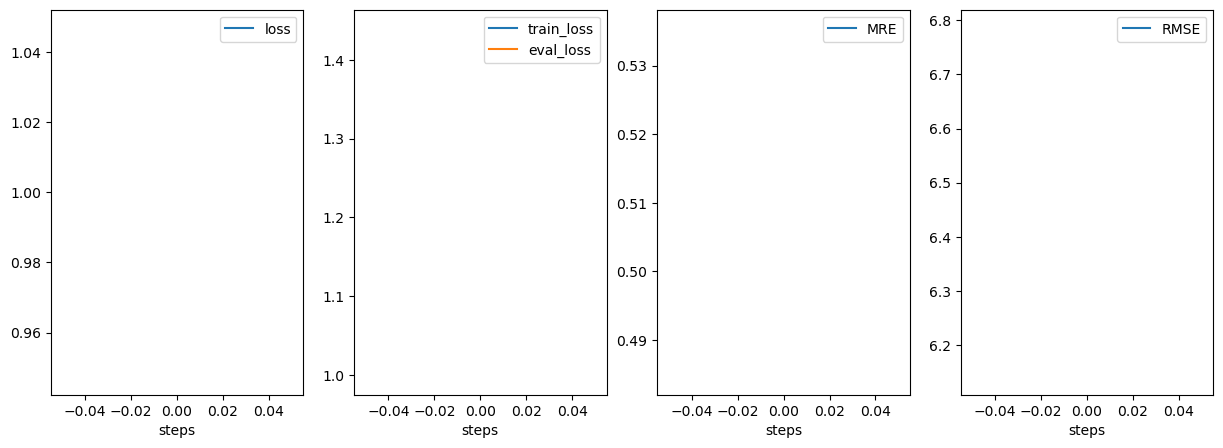

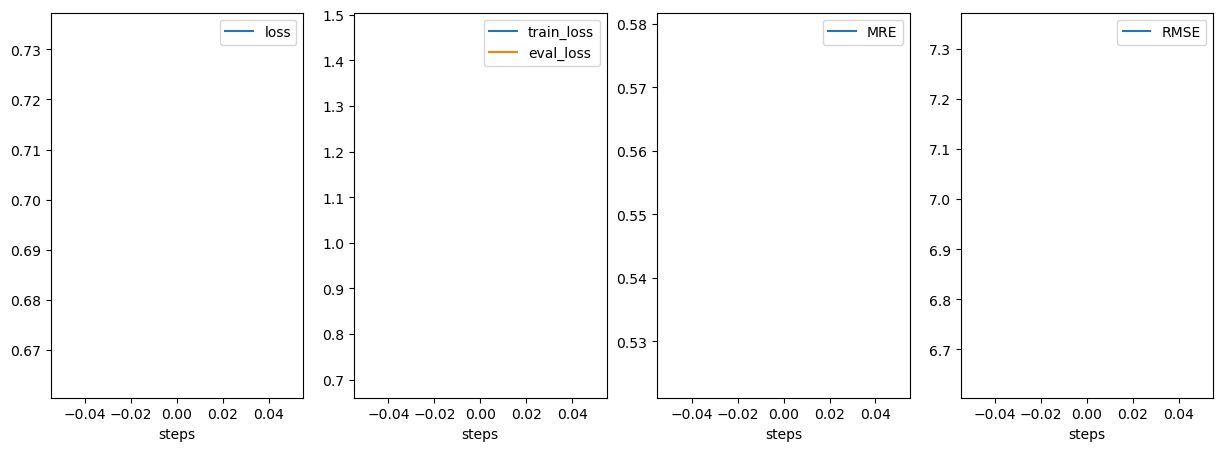

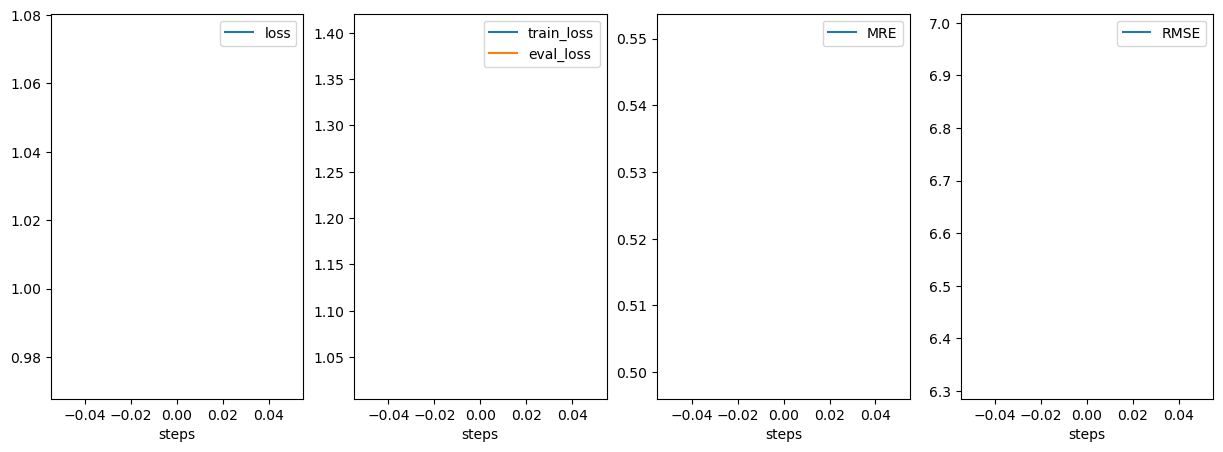

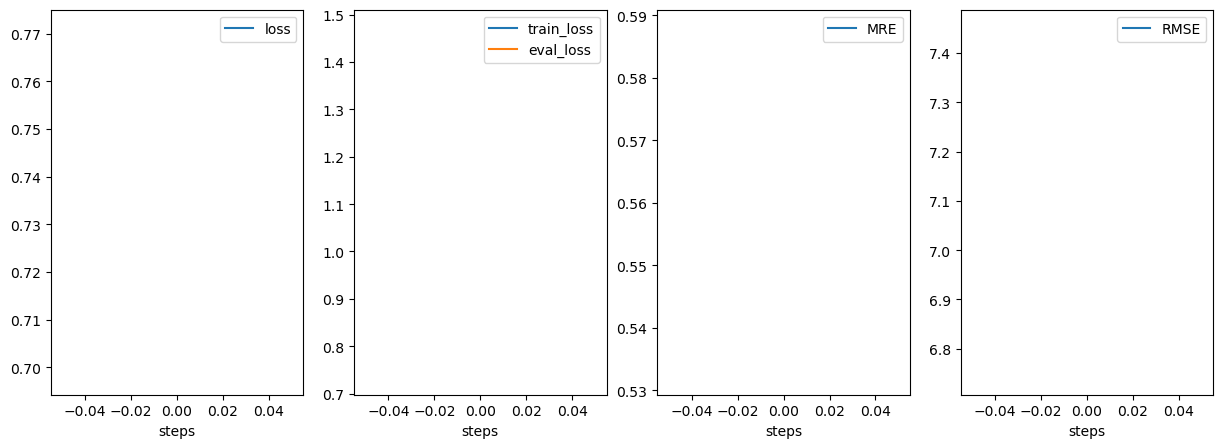

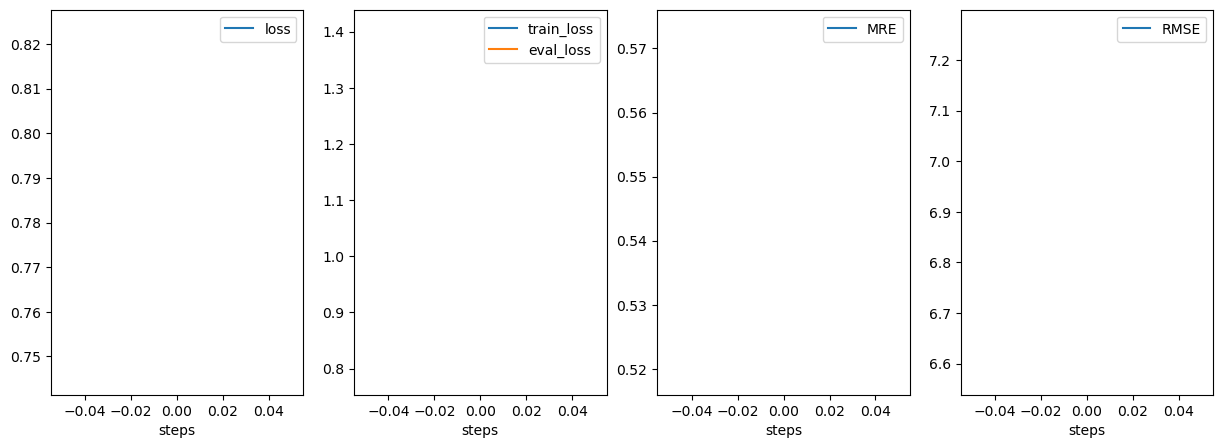

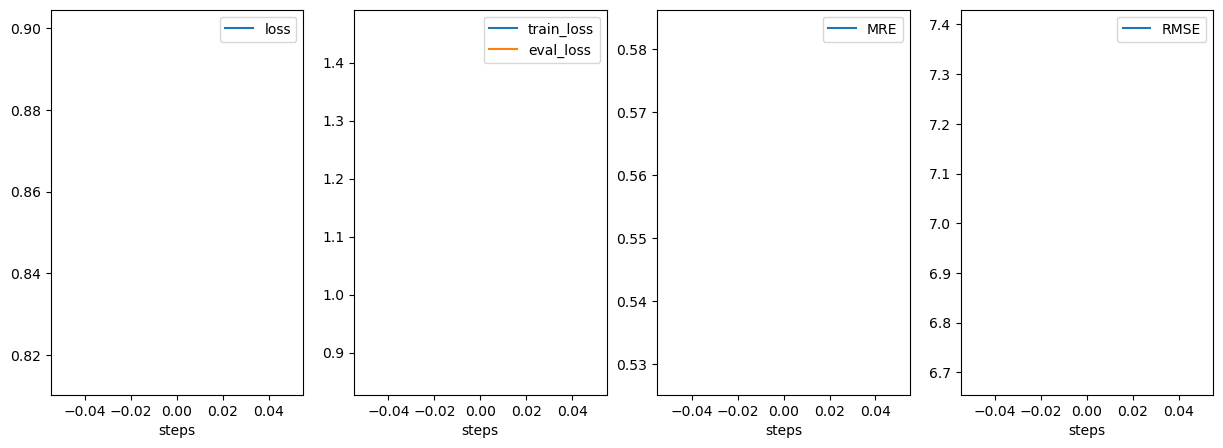

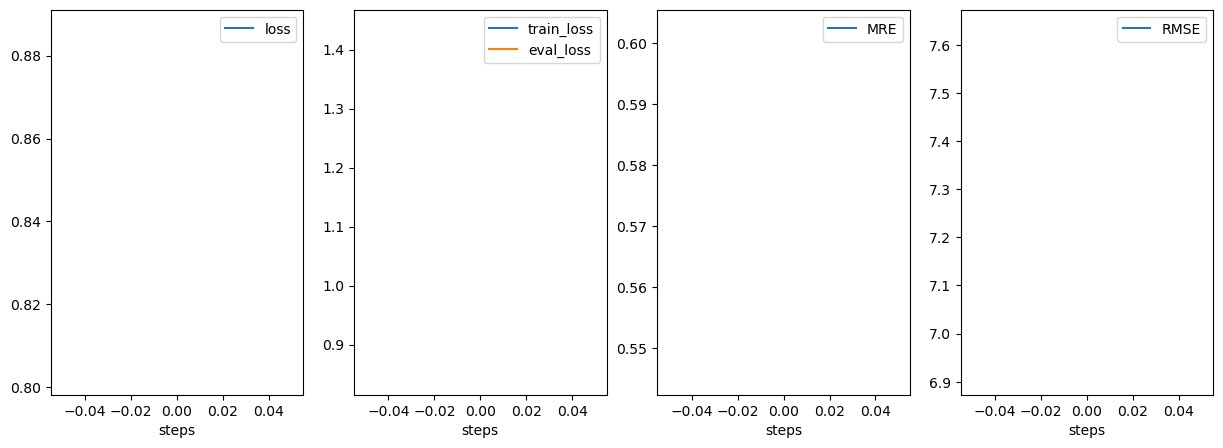

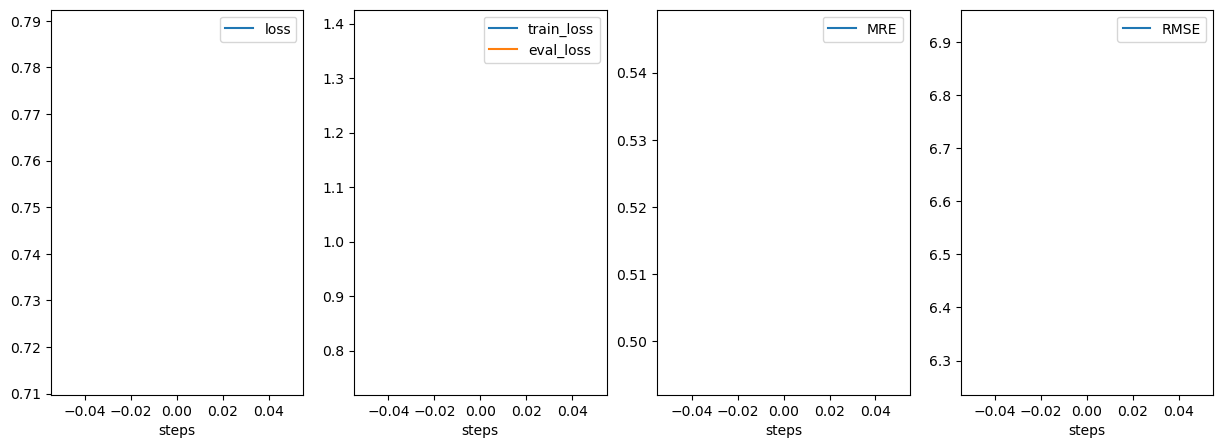

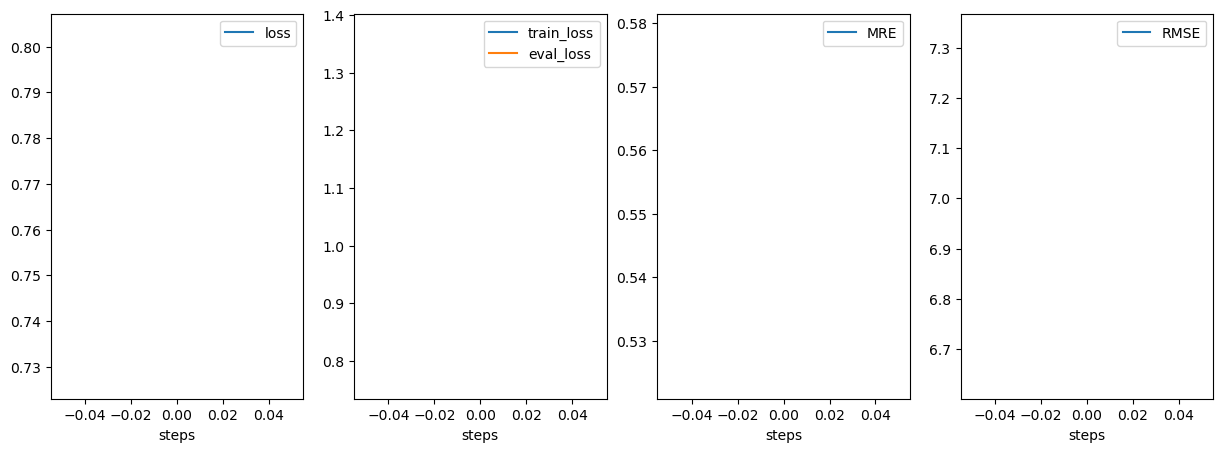

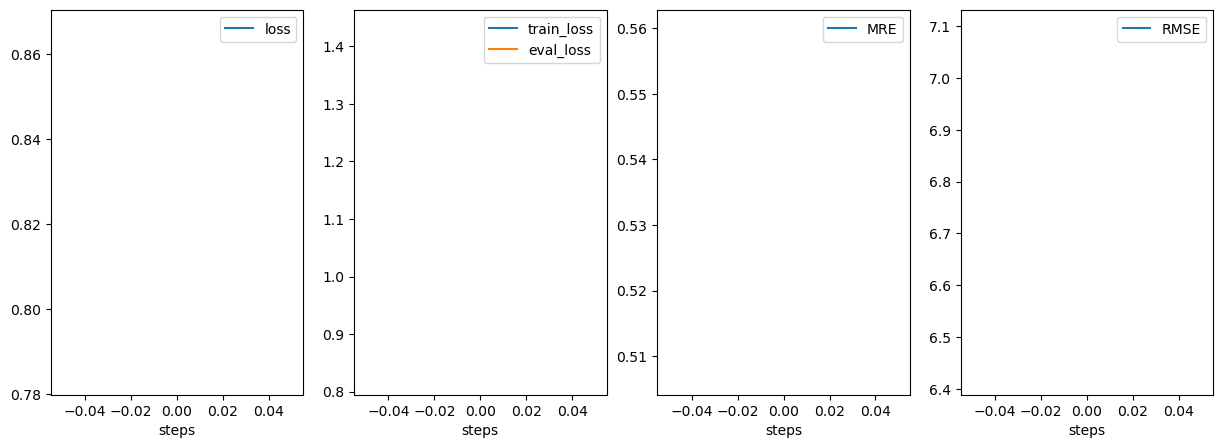

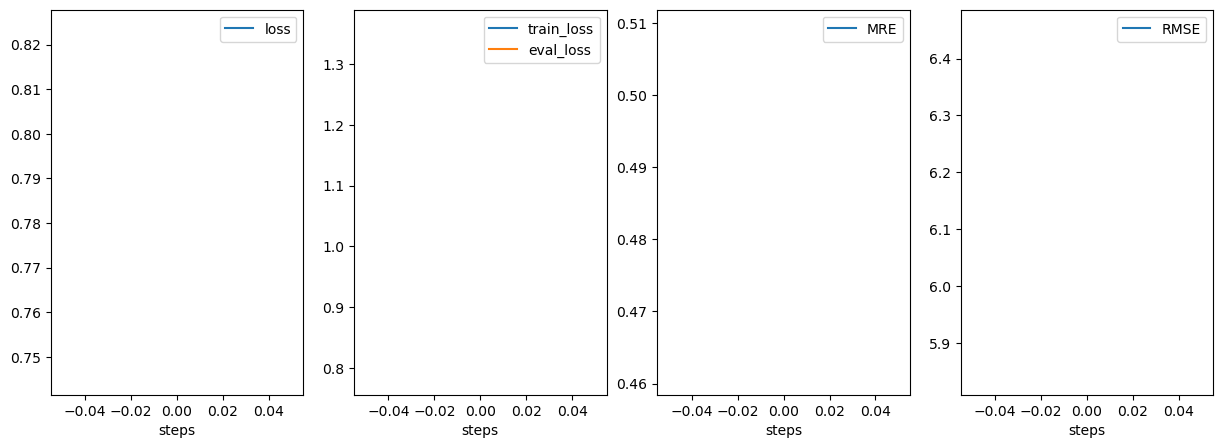

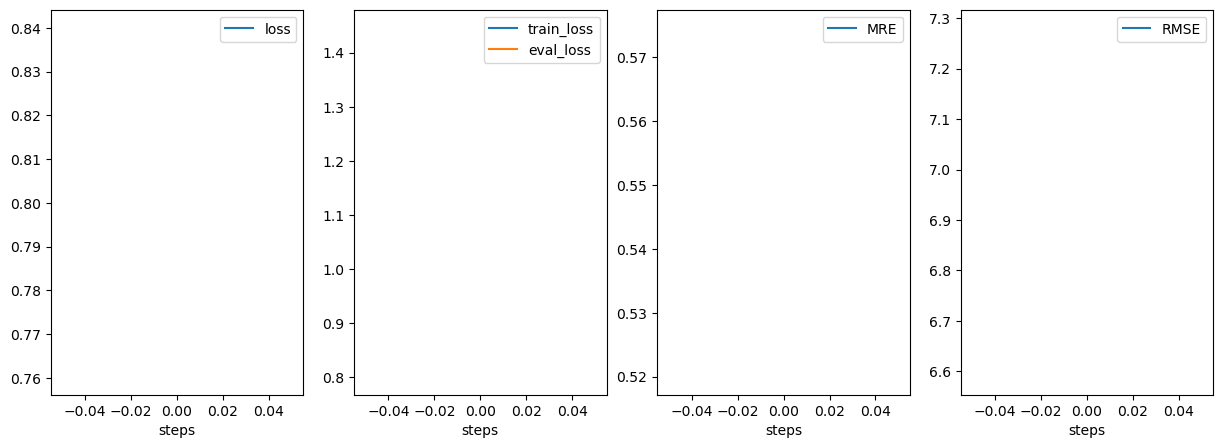

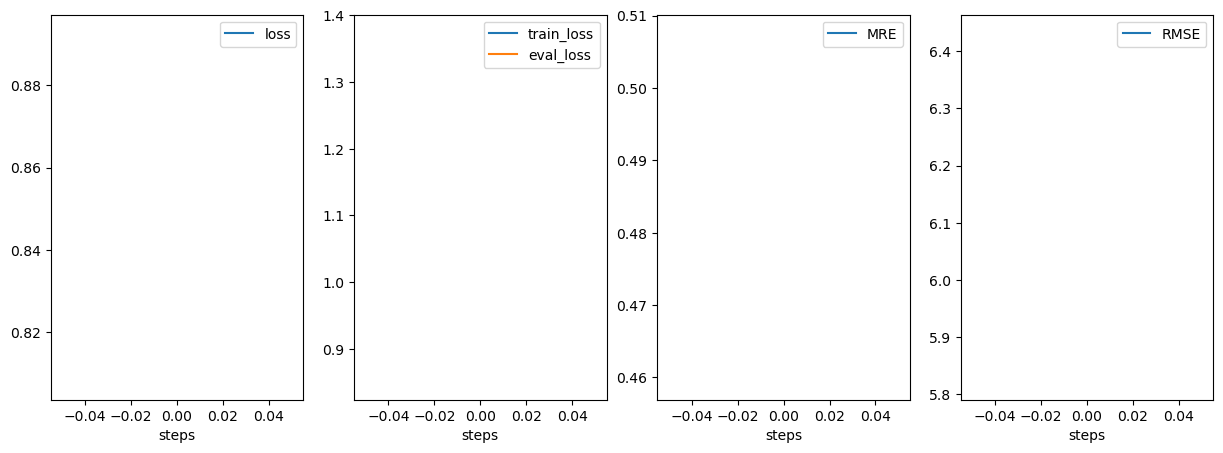

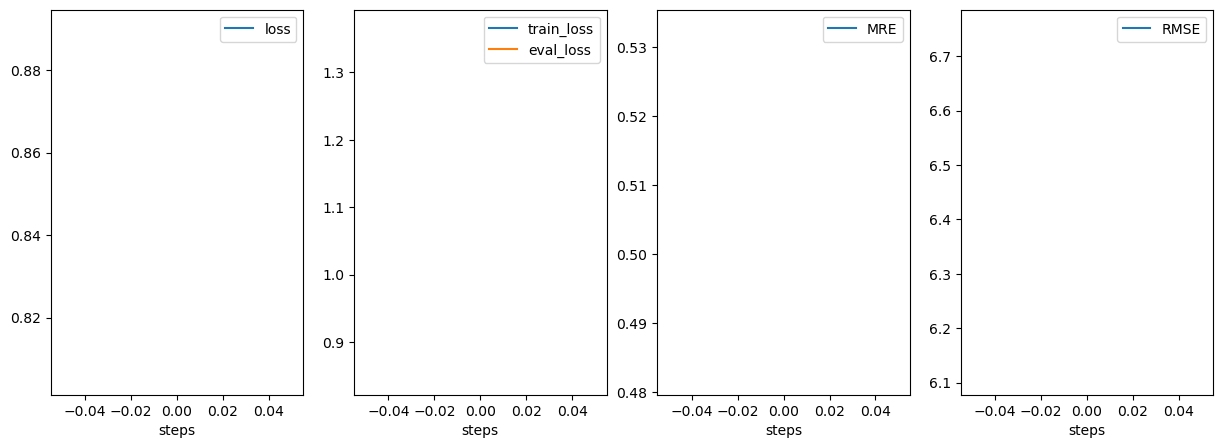

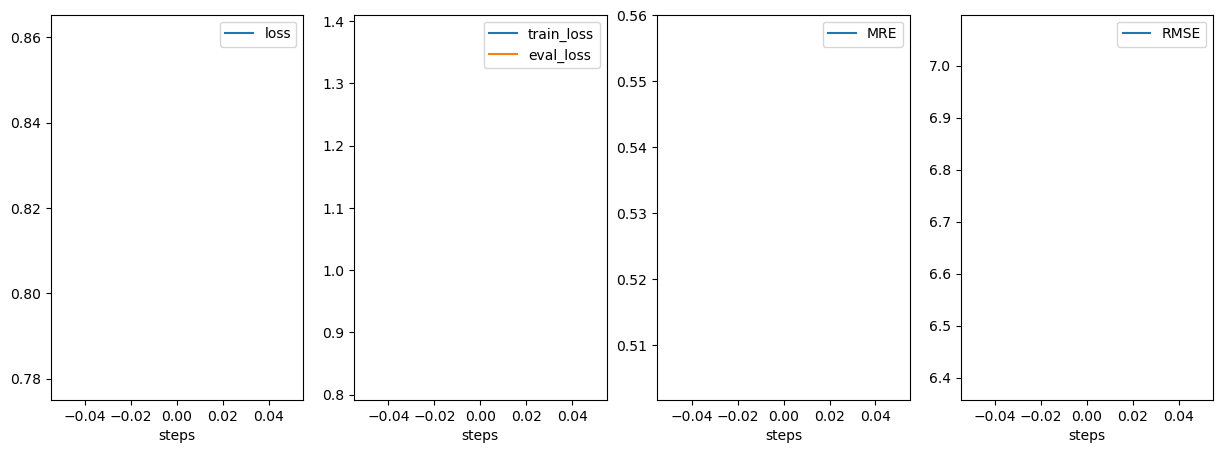

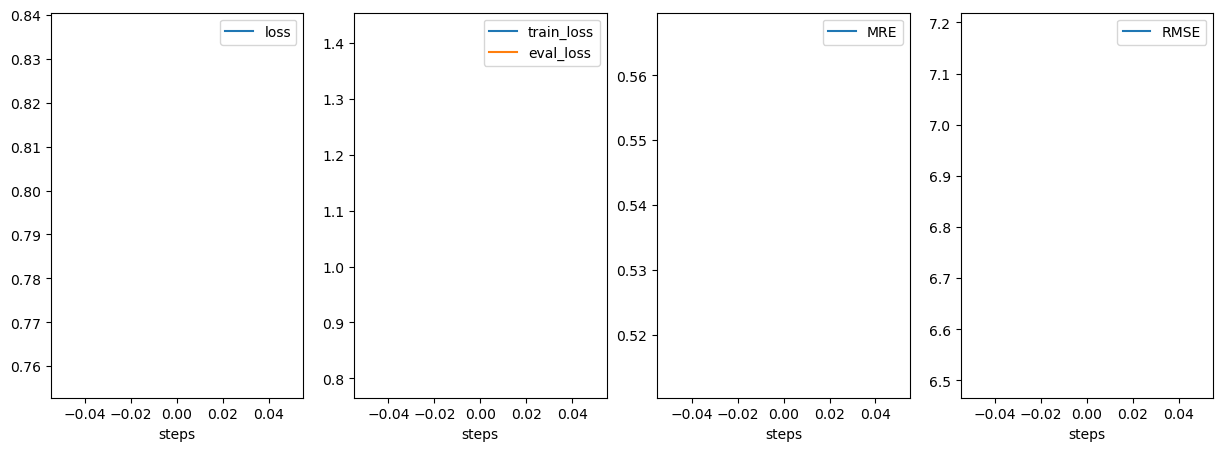

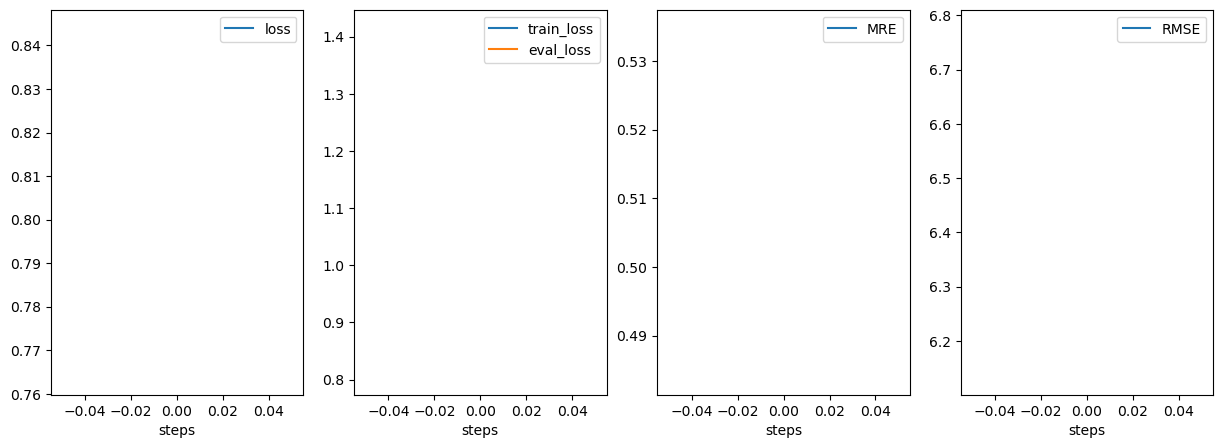

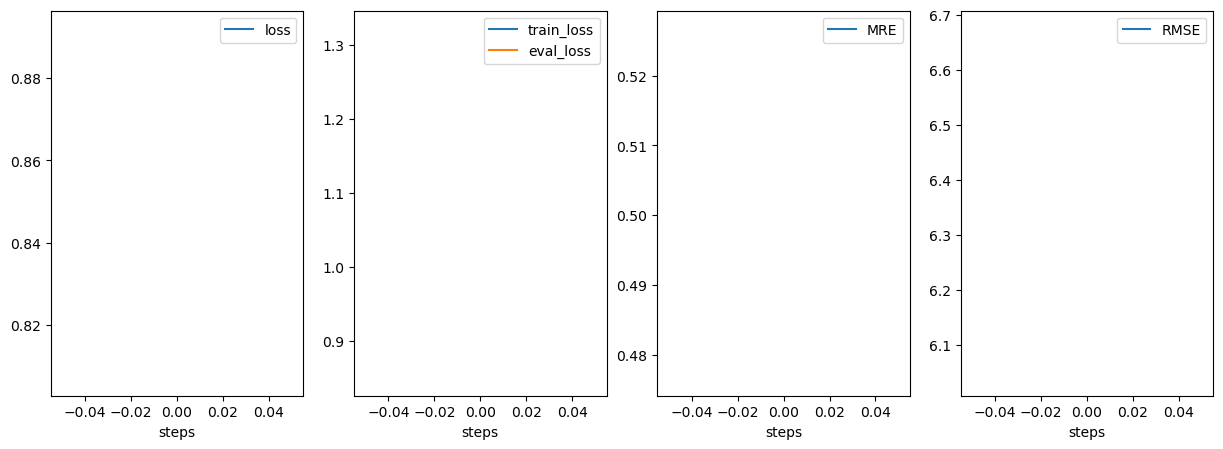

In [19]:
from executor import grid_search_loop
# reload(executor)
# grid_search_loop(
#     model_type,
#     conf,
#     preprocessed_train_ds,
#     preprocessed_eval_ds,
#     compute_evaluate_metrics,
#     to_device,
#     init_model,
# )